In [104]:
# 2020 IT 서비스 신기술 실습

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from google.colab import drive
drive.mount('/content/gdrive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import load_model


# 시계열 데이터 lag, time_step 고려 x, y 데이터로 변환
def seq_to_data(data, lag, time_step):
    x_data, y_data = [], []
    for i in range(len(data) - time_step):
        x = data[i:(i + time_step)]
        y = data[i + time_step]
        x_data.append(x)
        y_data.append(y)
    x_data = np.array(x_data[:-lag])
    y_data = np.array(y_data[lag:])
    return x_data, y_data

def convert_unixtime(data_time):
    import datetime
    unixtime = datetime.datetime.strptime(data_time,
                                          '%Y-%m-%d').timestamp()
    unixtime = int(unixtime)
    unixtime = str(unixtime)
    return unixtime

# 데이터로드
def get_nasdaq_daily(start, end):
    # YYYY-MM-DD
    unix_start = convert_unixtime(start)
    unix_end = convert_unixtime(end)
    url = 'https://query1.finance.yahoo.com/v7/finance/download/%5EIXIC?period1='+unix_start+'&period2='+unix_end+'&interval=1d&events=history&includeAdjustedClose=true'
    dataset = pd.read_csv(url,index_col="Date")
    return dataset

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [105]:
# 데이터 분할 함수
def split(data):
    train_size = int(len(data)*0.6)
    val_size = int(len(data)*0.8)
    data_train = data[:train_size]
    data_val = data[train_size:val_size]
    data_test = data[val_size:]
    return data_train, data_val, data_test

In [106]:
# 데이터 정규화 함수
def normalization(data_train, data_val, data_test):
    scaler = MinMaxScaler() #StandardScaler
    scaler.fit(data_train)
    n_data_train = scaler.transform(data_train)
    n_data_val = scaler.transform(data_val)
    n_data_test = scaler.transform(data_test)
    return n_data_train, n_data_val, n_data_test

In [107]:
# 모델 생성 함수
def build_reg_model(x_train):
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape = (20,1), return_sequences = True))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse', metrics=['mse'])
    return model

In [108]:
# 학습 시각화 함수
def learning_graph(hist):
    fig, loss_ax = plt.subplots()
    loss_ax.plot(hist.history['loss'],'g', label='train loss')
    loss_ax.plot(hist.history['val_loss'],'b', label='val loss')
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(loc='upper left')
    plt.show()

In [109]:
# 함수 활용 실행

# 랜덤시드 고정
np.random.seed(5)

# 데이터 로드
dataset = get_nasdaq_daily('2015-12-12','2020-12-14')
print(dataset)

dataset = dataset.drop(columns=["Open","High","Low","Adj Close","Volume"])

print(dataset)
#print(dataset['Close'].describe())
#dataset = dataset.values
#print(dataset)

# 데이터 분할 
close = dataset['Close']
x, y = seq_to_data(close,2,3)
#print(x)
#print(y)

x_train, x_val, x_test = split(x)
y_train, y_val, y_test = split(y)

# 데이터 정규화
x_train, x_val, x_test = normalization(x_train, x_val, x_test)




                    Open          High  ...     Adj Close      Volume
Date                                    ...                          
2015-12-14   4932.609863   4953.600098  ...   4952.229980  2216060000
2015-12-15   4991.209961   5026.540039  ...   4995.359863  2054710000
2015-12-16   5033.479980   5078.990234  ...   5071.129883  2036610000
2015-12-17   5087.169922   5088.580078  ...   5002.549805  1897220000
2015-12-18   4982.580078   4996.490234  ...   4923.080078  3765210000
...                  ...           ...  ...           ...         ...
2020-12-07  12461.000000  12536.230469  ...  12519.950195  4741690000
2020-12-08  12503.169922  12594.540039  ...  12582.769531  4758170000
2020-12-09  12591.690430  12607.139648  ...  12338.950195  5131720000
2020-12-10  12247.549805  12431.559570  ...  12405.809570  4470060000
2020-12-11  12336.790039  12383.500000  ...  12377.870117  4268140000

[1259 rows x 6 columns]
                   Close
Date                    
2015-12-14   49

In [110]:
# 모델 생성
model = build_reg_model(x_train)
#print(x_train)
#print(x_train)
#print(type(x_train))
#print(y_train)


In [111]:
# 훈련,검증 데이터 훈련

x_train = x_train.reshape((x_train.shape[0],x_train.shape[1],1))
x_test = x_test.reshape((x_test.shape[0],x_test.shape[1],1))
x_val = x_val.reshape((x_val.shape[0],x_val.shape[1],1))

callbacks_list = [
            EarlyStopping(monitor='val_loss', patience=100,),
            ModelCheckpoint(filepath='best_model.h5', monitor='val_loss',
            save_best_only=True, )]
hist = model.fit(x_train, y_train, epochs=500, callbacks=callbacks_list, validation_data=(x_val,y_val),shuffle=False)


Epoch 1/500
24/24 [==============================] - 0s 20ms/step - loss: 39542164.0000 - mse: 39542164.0000 - val_loss: 61739120.0000 - val_mse: 61739120.0000
Epoch 2/500
24/24 [==============================] - 0s 10ms/step - loss: 39535764.0000 - mse: 39535764.0000 - val_loss: 61717928.0000 - val_mse: 61717928.0000
Epoch 3/500
24/24 [==============================] - 0s 10ms/step - loss: 39488628.0000 - mse: 39488628.0000 - val_loss: 61520756.0000 - val_mse: 61520756.0000
Epoch 4/500
24/24 [==============================] - 0s 10ms/step - loss: 39158400.0000 - mse: 39158400.0000 - val_loss: 60443784.0000 - val_mse: 60443784.0000
Epoch 5/500
24/24 [==============================] - 0s 10ms/step - loss: 37827300.0000 - mse: 37827300.0000 - val_loss: 56663276.0000 - val_mse: 56663276.0000
Epoch 6/500
24/24 [==============================] - 0s 11ms/step - loss: 34238296.0000 - mse: 34238296.0000 - val_loss: 48669984.0000 - val_mse: 48669984.0000
Epoch 7/500
24/24 [=====================

In [112]:
# 모델 저장하기
from keras.models import load_model
model.save('/content/gdrive/My Drive/Colab Notebooks/best_model.h5')


In [113]:
#print(x_train)
#print(x_test)
#print(y_train)
#print(hist.history)


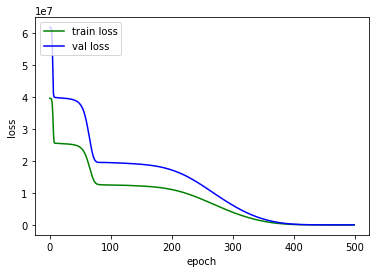

In [114]:
# 훈련 검증 셋 비교
learning_graph(hist)


In [115]:

#print(y_test)
#print(y_test.shape[0])
#print(y_val)
#print(y_predict)
#print(len(y_test))
#print(len(y_val))
#print(len(y_train))

In [116]:
# 예측하기

y_predict = model.predict(x_test)

#print(x_test)
#print(len(y_predict))
#print(y_predict.shape)

In [117]:
# 데이터 셋 shape 조정

y_pred = y_predict.reshape(-1)

# print(y_predict)
# print(len(y_predict))

# y_pre: y예측값

y_pre=[]
for i in range(2,len(y_pred),3):
  y_pre.append(y_pred[i])
print(y_pre)
print(len(y_pre))


[8632.564, 8627.256, 8664.111, 8725.496, 8742.718, 8819.565, 8828.473, 8832.911, 8890.6045, 8927.198, 8947.313, 8954.477, 9021.647, 9006.253, 8947.763, 8973.761, 9089.36, 9020.374, 9069.494, 9066.934, 9125.805, 9197.624, 9174.079, 9266.014, 9244.265, 9251.688, 9346.985, 9377.725, 9360.236, 9372.737, 9390.432, 9305.377, 9135.82, 9262.004, 9267.224, 9289.949, 9147.277, 9266.324, 9454.731, 9494.228, 9555.594, 9505.939, 9610.404, 9620.826, 9704.976, 9691.495, 9710.162, 9711.829, 9793.1455, 9728.296, 9558.435, 9214.037, 8966.249, 8979.834, 8579.133, 8580.748, 8952.903, 8693.998, 9016.408, 8744.808, 8585.742, 7980.837, 8360.506, 7979.058, 7251.5146, 7902.895, 6961.007, 7378.657, 7043.394, 7199.0273, 6935.7534, 6918.834, 7461.0605, 7429.2627, 7829.9, 7544.084, 7807.322, 7734.6987, 7405.269, 7528.596, 7419.054, 7943.4565, 7918.8633, 8116.515, 8177.6924, 8216.069, 8529.112, 8410.888, 8545.92, 8659.44, 8572.301, 8284.736, 8509.765, 8509.621, 8645.107, 8737.69, 8619.937, 8916.78, 8891.778, 8616.6

In [118]:
#print(y_val)
#print(len(y_val))

# RMSE 구하기 (훈련,검증)
rmse = np.sqrt(mean_squared_error(y_pre, y_val))


print("RMSE of train: %.3f"%np.sqrt(hist.history['loss'][-1]))
print("RMSE of val  : %.3f"%np.sqrt(hist.history['val_loss'][-1]))

RMSE of train: 137.072
RMSE of val  : 172.628


In [119]:
#print(y_test)
#print(y_test.shape)
#y_test = y_test.reshape((y_test.shape[0],y_test.shape[1],1))
#print(y_test)
#print(y_test.shape)
#print(y_predict.shape)



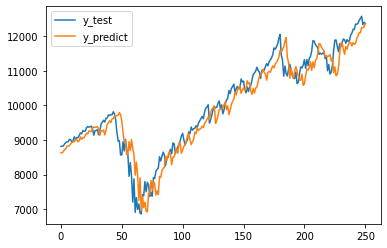

In [120]:
# 실제값, 예측값 그래프
fig, loss_ax = plt.subplots()
loss_ax.plot(y_test, label='y_test')
loss_ax.plot(y_pre, label='y_predict')
loss_ax.legend(loc='upper left')
plt.show()

In [121]:
df = pd.DataFrame(y_test,index=dataset[-251:].index)
df.insert(1,'y_predict',y_pre)
df.rename(columns={0:'y_test'}, inplace=True)
print(df)


#df_predict=pd.DataFrame(y_pre,index=dataset[-251:].index, columns=['Predictions'])
#df_test=pd.concat([df,df_predict],axis=1)
#print(df_test)

                  y_test     y_predict
Date                                  
2019-12-16   8814.230469   8632.564453
2019-12-17   8823.360352   8627.255859
2019-12-18   8827.740234   8664.111328
2019-12-19   8887.219727   8725.496094
2019-12-20   8924.959961   8742.717773
...                  ...           ...
2020-12-07  12519.950195  12105.067383
2020-12-08  12582.769531  12256.206055
2020-12-09  12338.950195  12250.820312
2020-12-10  12405.809570  12277.984375
2020-12-11  12377.870117  12362.327148

[251 rows x 2 columns]


In [122]:
df.tail()

,y_test,y_predict
Date,,
2020-12-07,12519.950195,12105.067383
2020-12-08,12582.769531,12256.206055
2020-12-09,12338.950195,12250.820312
2020-12-10,12405.809570,12277.984375
2020-12-11,12377.870117,12362.327148


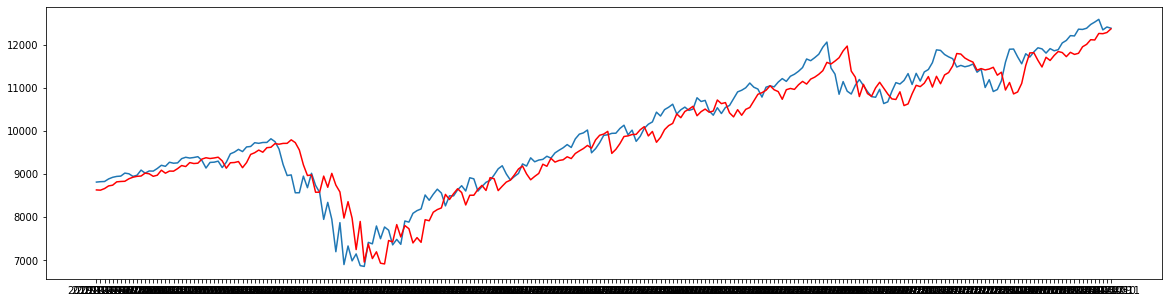

In [123]:
plt.figure(figsize=(20,5))
plt.plot(df['y_test'])   #df_test.index를 df_test['price']로 줌
plt.plot(df['y_predict'],color='r')
plt.show()

In [124]:
# 모델 로드
from keras.models import load_model
model = load_model('best_model.h5')

In [125]:
# 미래 주가 예측을 위한 데이터 셋 만들기

dates = ['2020-12-14','2020-12-15','2020-12-16','2020-12-17','2020-12-18',
         '2020-12-21','2020-12-22','2020-12-23','2020-12-24','2020-12-25']
         
#ts_dates = pd.to_datetime(dates)

In [126]:
print(dataset)
#print(dataset.shape)

future_dates=pd.DataFrame(index=dates[0:], columns=df.columns)
#print(future_dates)

# 데이터 프레임 만들기 
result = pd.concat([dataset,future_dates])
print(result)

                   Close
Date                    
2015-12-14   4952.229980
2015-12-15   4995.359863
2015-12-16   5071.129883
2015-12-17   5002.549805
2015-12-18   4923.080078
...                  ...
2020-12-07  12519.950195
2020-12-08  12582.769531
2020-12-09  12338.950195
2020-12-10  12405.809570
2020-12-11  12377.870117

[1259 rows x 1 columns]
                  Close y_test y_predict
2015-12-14  4952.229980    NaN       NaN
2015-12-15  4995.359863    NaN       NaN
2015-12-16  5071.129883    NaN       NaN
2015-12-17  5002.549805    NaN       NaN
2015-12-18  4923.080078    NaN       NaN
...                 ...    ...       ...
2020-12-21          NaN    NaN       NaN
2020-12-22          NaN    NaN       NaN
2020-12-23          NaN    NaN       NaN
2020-12-24          NaN    NaN       NaN
2020-12-25          NaN    NaN       NaN

[1269 rows x 3 columns]


In [127]:
last_7_days = dataset['Close']
#last_7_days = np
last_7_days = last_7_days.values.reshape(-1,1)
scaler = MinMaxScaler() #StandardScaler
scaler.fit(last_7_days)
last_7_days_scaled = scaler.transform(last_7_days)

test = []
test.append(last_7_days_scaled)
test = np.array(x_test)
test = np.reshape(test, (test.shape[0], test.shape[1], 1))

#예측
pred_price = model.predict(test)

In [128]:
#print(pred_price)
#print(pred_price.shape)

print(pred_price[-1,-1,:])

# 다음 날 종가
a = pred_price[-1,-1,-1]
print(a)

dataset.loc['2020-12-14']= a
print(dataset)

[12362.327]
12362.327
                   Close
Date                    
2015-12-14   4952.229980
2015-12-15   4995.359863
2015-12-16   5071.129883
2015-12-17   5002.549805
2015-12-18   4923.080078
...                  ...
2020-12-08  12582.769531
2020-12-09  12338.950195
2020-12-10  12405.809570
2020-12-11  12377.870117
2020-12-14  12362.327148

[1260 rows x 1 columns]
